In [1]:
# import os
import sys

sys.path.insert(0, r"/mnt/c/Users/Trez/Desktop/tudat-bundle/tudatpy/")
import numpy as np
import datetime

from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation, estimation_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation

# from astropy.time import Time
from astropy.coordinates import EarthLocation
from astropy import units as u

# from pac.data import BatchMPC
from tudatpy.data.mpc import BatchMPC
from tudatpy.data.horizons import HorizonsQuery
# import tudatpy.data as data

import matplotlib.pyplot as plt



ModuleNotFoundError: No module named 'tudatpy.data.horizons'

In [ ]:
centre = "Sun"
# centre = "SSB"

In [ ]:
# SPICE KERNELS
spice.load_standard_kernels()
# spice.load_kernel(r"codes_300ast_20100725.bsp")
# spice.load_kernel(r"codes_300ast_20100725.tf")

In [ ]:
codes = [433, 1, 4]
codes = [433, 1, 4, 21]
codes = [162173, 887, 433]
codes = [887, 433]
codes = [1036, 433, 329]
codes = [238, 200, 433, 329]
codes = [238, 433, 329]
# codes = [433, 101955 ,162173]
# codes = [433, 21, 253]
# codes = [1,2,3,4,5,6,7,8,9,10]

start_dt = datetime.datetime(2019, 1, 1)
end_dt = datetime.datetime(2023, 6, 1)

start_dt_buff = datetime.datetime(2018, 8, 1)
end_dt_buff = datetime.datetime(2023, 8, 1)

batch = BatchMPC()
batch.get_observations(codes)
batch.filter(
    epoch_start=start_dt,
    epoch_end=end_dt,
    observatories_exclude=["C59", "C57"],
)

batch.summary()
# batch.plot_observations(objects=["2"])
# batch.plot_observations()
start_sec = batch.epoch_start
end_sec = batch.epoch_end

print(batch.observatories_table(only_in_batch=True, only_space_telescopes=True, include_positions=False))


   Batch Summary:
1. Batch includes 3 minor planets:
   ['238', '433', '329']
2. Batch includes 4455 observations, including 250 observations from space telescopes
3. The observations range from 2019-01-02 17:36:35.136005 to 2023-05-29 11:10:29.827215
   In seconds TDB since J2000: 599722664.3199787 to 738630699.0121946
   In Julian Days: 2458486.23374 to 2460093.965623
4. The batch contains observations from 63 observatories, including 1 space telescopes

     Code  Name  count
1225  C51  WISE  250.0


In [ ]:
# buffer to avoid interpolation at the edges of the estimated ephemeris
buffer = 86400 * 2

times_inter = np.linspace(start_sec + buffer, end_sec - buffer, 100)

In [ ]:
names = {}
carthesians = {}
# {162173: 'Ryugu', 887: 'Alinda', 433: 'Eros'}

for u in codes:
    temp = HorizonsQuery(
        query_id=f"{u};",
        location=f"@{centre}",
        epoch_list=list(times_inter),
        extended_query=True
    )
    carthesians[u] = temp.carthesian("earth")[:, 1:]
    names[u] = temp.name

print(list(names.values()))
print(names)

['Hypatia', 'Eros', 'Svea']
{238: 'Hypatia', 433: 'Eros', 329: 'Svea'}


In [ ]:
bodies_to_propagate = batch.MPC_objects
central_bodies = [centre for _ in batch.MPC_objects]
bodies_to_create = [
    "Sun",
    "Mercury",
    "Venus",
    "Earth",
    "Moon",
    "Mars",
    "Jupiter",
    "Saturn",
    "Uranus",
    "Neptune",
]

accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}



In [ ]:
wise_query = HorizonsQuery(
    query_id="WISE",
    location=f"@{centre}",
    epoch_start=start_dt_buff,
    epoch_end=end_dt_buff,
    epoch_step="6h",
    extended_query=True
)
tess_query = HorizonsQuery(
    query_id="TESS",
    location=f"@{centre}",
    epoch_start=start_dt_buff,
    epoch_end=end_dt_buff,
    epoch_step="6h",
    extended_query=True
)

In [ ]:
global_frame_origin = centre
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation
)

# # NOTE this way produces settings, the ephemeris itself is made by tudat
# body_settings.add_empty_settings("TESS")
# body_settings.get("TESS").ephemeris_settings = tess_query.create_ephemeris_tabulated(
#     frame_origin=global_frame_origin,
#     frame_orientation=global_frame_orientation,
# )
body_settings.add_empty_settings("WISE")
body_settings.get("WISE").ephemeris_settings = wise_query.create_ephemeris_tabulated(
    frame_origin=global_frame_origin,
    frame_orientation=global_frame_orientation,
)


# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)
satellites_to_include = {"C57": "TESS", "C51": "WISE"}
satellites_to_include = {"C51": "WISE"}

In [ ]:
observation_collection, links = batch.to_tudat(bodies=bodies, included_satellites=satellites_to_include)
observation_settings_list = list()
for link in list(links.values()):
    observation_settings_list.append(observation.angular_position(link))

In [ ]:
end = batch.epoch_end + 8*86400
start = batch.epoch_start - 8*86400

In [ ]:
acceleration_settings = {}
for body in batch.MPC_objects:
    acceleration_settings[str(body)] = accelerations

# acceleration_settings["TESS"] = allAccels

acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

In [ ]:

initial_states = np.array([])
initial_states_clean = np.array([])
for code in codes:
    print(names[code])
    try:
        temp = spice.get_body_cartesian_state_at_epoch(str(code+2000000), centre, "J2000", "NONE", end)
        print(code)
        print(names[code])
    except:
        print(code)
        print(names[code])
        temp = spice.get_body_cartesian_state_at_epoch(names[code], centre, "J2000", "NONE", end)

    initial_states_clean = np.concatenate([initial_states_clean, temp])
    temp[0:3] += + np.random.rand(3)*1000e3
    temp[3:6] += + np.random.rand(3)*10

    initial_states = np.concatenate([initial_states, temp])


Hypatia
238
Hypatia
Eros
433
Eros
Svea
329
Svea


In [ ]:
termination_condition = propagation_setup.propagator.time_termination(start)


dt = -60000
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    end, dt, propagation_setup.integrator.rkf_78, dt, dt, 1.0, 1.0
)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=central_bodies,
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_states,
    initial_time=end,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition,
)

In [ ]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(
    propagator_settings, bodies
)

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)

print(central_bodies)
print(bodies_to_propagate)

['Sun', 'Sun', 'Sun']
['238', '433', '329']


In [ ]:

estimator = numerical_simulation.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_settings_list,
    propagator_settings=propagator_settings,
    integrate_on_creation=True, 
)


pod_input = estimation.EstimationInput(
    observations_and_times=observation_collection,
    convergence_checker=estimation.estimation_convergence_checker(
        maximum_iterations=4,
    )
)

In [ ]:
pod_input.define_estimation_settings(reintegrate_variational_equations=True)


In [ ]:
pod_output = estimator.perform_estimation(pod_input)
results = parameters_to_estimate.parameter_vector
results = pod_output.parameter_history[:, -1]

Calculating residuals and partials 8910
Parameter update  6.5095e+06 -3.22602e+07 -3.97219e+06     -7.42183     -10.9269     -5.15939 -4.18299e+07 -2.61729e+06  6.76622e+07     -1.04262     -2.47295     -2.23884      -511946      -480770      -634026     -1.27742     -4.95874     -1.77912
Current residual: 0.0124686
Calculating residuals and partials 8910
Parameter update-6.87719e+06  3.15468e+07  3.45566e+06    -0.958761      1.13258     0.346055  4.11484e+07  1.77505e+06  -6.7721e+07     -6.10674      2.44161     0.669397      -182972     -677.639        20134  -0.00419553  -0.00534969 -0.000748221
Current residual: 0.000488389
Calculating residuals and partials 8910
Parameter update    -439.119     -861.175      70.0581 -4.44011e-05 -3.32538e-05  5.60305e-06     -5598.03        93539      -135162  0.000158494  -0.00413063   0.00723023    0.0217809    -0.025951     0.026708  1.71405e-09 -1.53839e-09  1.24652e-09
Current residual: 6.94088e-06
Calculating residuals and partials 8910
Pa

In [ ]:
# print(f"Eros radial error: {np.sqrt(np.square((np.array(result_eros) - initial_state_Eros)[0:3]).sum())/1000} km")
# print(f"Ceres radial error: {np.sqrt(np.square((np.array(result_ceres) - initial_state_Ceres)[0:3]).sum())/1000} km")
# print(f"Vesta radial error: {np.sqrt(np.square((np.array(result_vesta) - initial_state_Vesta)[0:3]).sum())/1000} km")

for i, name in enumerate(list(names.values())):
    error = np.sqrt(np.square((np.array(results[int(6*i):(6*(i+1))]) - initial_states_clean[int(6*i):(6*(i+1))])[0:3]).sum())/1000
    print(f"{name} radial error: {round(error, 4)}")

Hypatia radial error: 247.6378
Eros radial error: 123.7206
Svea radial error: 169.0301


(8910, 4)
8970


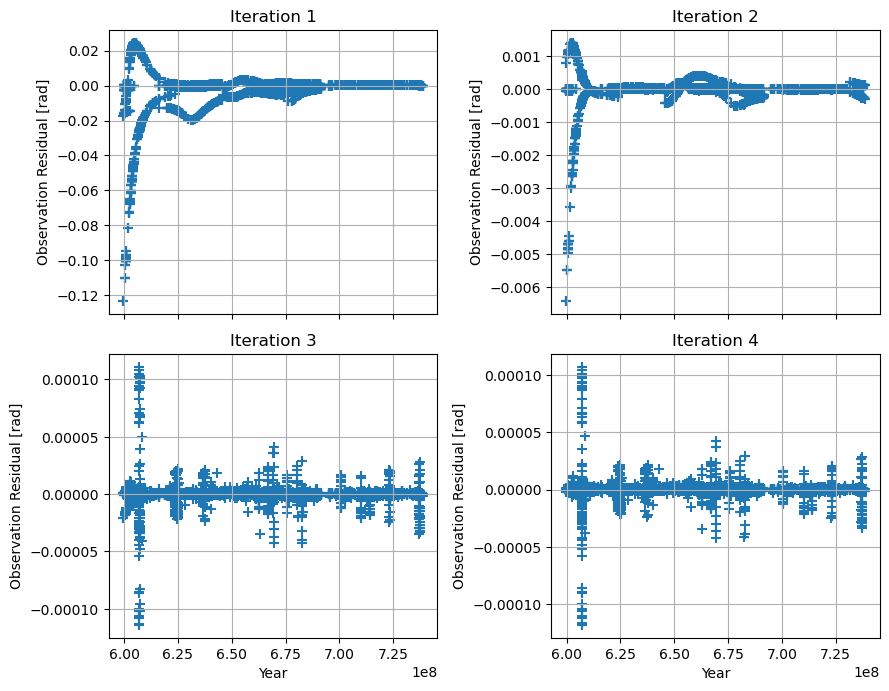

In [ ]:
residual_history = pod_output.residual_history
print(residual_history.shape)
fig, axs = plt.subplots(2, 2, figsize=(9, 7), sharex=True, sharey=False)

# a little trick to retrieve the UTC times from the batch, table retrieves all observations in pandas format
times = (
    batch.table
    .set_index("epochJ2000secondsTDB")
    .loc[observation_collection.concatenated_times]
    .epochUTC
    # .sort_values()
    .tolist()
)
print(len(times))

for idx, ax in enumerate(fig.get_axes()):
    ax.grid()
    ax.scatter(observation_collection.concatenated_times, residual_history[:, idx], marker="+", s=60)
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_title("Iteration " + str(idx + 1))

plt.tight_layout()

axs[1, 0].set_xlabel("Year")
axs[1, 1].set_xlabel("Year")

plt.show()

/tmp/ipykernel_18601/2038681788.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


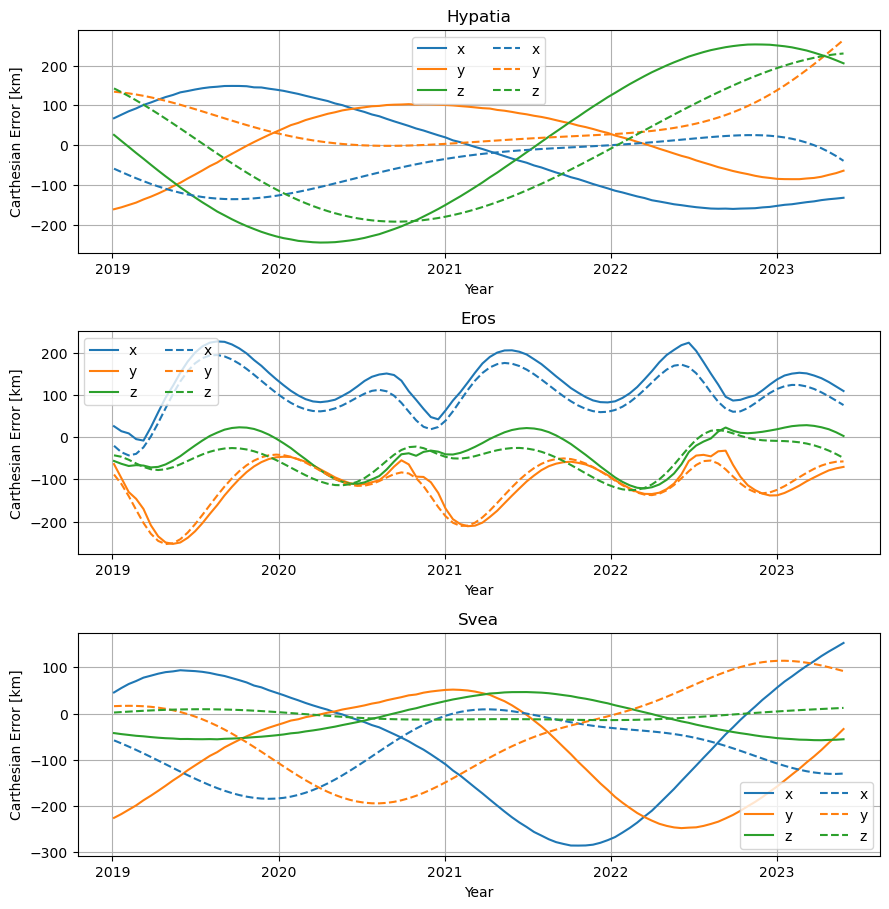

In [ ]:
fig, ax = plt.subplots(len(codes), 1, figsize=(9, int(3*len(codes))))

for i, code in enumerate(codes):
    spice_states = []
    estimation_states = []

    times_plot = times_inter/(86400*365.25) + 2000 # approximate
    for time in times_inter:
        # from spice
        state_spice = spice.get_body_cartesian_state_at_epoch(str(code+2000000), central_bodies[0], "J2000", "NONE", time)

        spice_states.append(state_spice)
        
        # from estimation
        state_est = bodies.get(str(code)).ephemeris.cartesian_state(time)
        estimation_states.append(state_est)

    # Error in kilometers
    error = (np.array(spice_states) - np.array(estimation_states)) / 1000
    error_jpl = (np.array(carthesians[code]) - np.array(estimation_states)) / 1000

    ax[i].plot(times_plot, error[:, 0], label="x")
    ax[i].plot(times_plot, error[:, 1], label="y")
    ax[i].plot(times_plot, error[:, 2], label="z")
    ax[i].plot(times_plot, error_jpl[:, 0], label="x", color="tab:blue", linestyle="--")
    ax[i].plot(times_plot, error_jpl[:, 1], label="y", color="tab:orange", linestyle="--")
    ax[i].plot(times_plot, error_jpl[:, 2], label="z", color="tab:green", linestyle="--")

    ax[i].grid()
    ax[i].legend(ncol=2)

    ax[i].set_title(names[code])

    plt.tight_layout()

    ax[i].set_ylabel("Carthesian Error [km]")
    ax[i].set_xlabel("Year")

plt.show()